In [1]:
# Block 1: Imports
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

# Load networks and facilities
# First load raw data
raw_data = {
    # Networks
    'pipeline': gpd.read_file('./data1/main_pipelines.shp').to_crs('EPSG:3035'),
    'railway': gpd.read_file('./data1/railways_GL2017_EU27.shp').to_crs('EPSG:3035'),
    'road': gpd.read_file('./data1/roads_GL2017_EU27.shp').to_crs('EPSG:3035'),
    'waterway': gpd.read_file('./data1/iww_GL2017_EU27.shp').to_crs('EPSG:3035'),
    
    # Facilities
    'storage': gpd.read_file('./data1/Storage.shp').to_crs('EPSG:3035').assign(facility_type='storage'),
    'refinery': gpd.read_file('./data1/Refineries.shp').to_crs('EPSG:3035').assign(facility_type='refinery'),
    'station': gpd.read_file('./data1/rrt_GL2017_EU27.shp').to_crs('EPSG:3035').assign(facility_type='station'),
    'port': gpd.read_file('./data1/ports_GL2017_EU27.shp').to_crs('EPSG:3035').assign(facility_type='port')
}

# Then clean and select relevant columns
networks = {
    'pipeline': raw_data['pipeline'][['Status', 'Owner', 'Capacity', 'LengthKnow', 'Countries', 'geometry']],
    'railway': raw_data['railway'][['COUNTRY_CO', 'STAGE_OF_S', 'GEO_LENGTH', 'geometry']],
    'road': raw_data['road'][['COUNTRY_CO', 'STAGE_OF_S', 'GEO_LENGTH', 'geometry']],
    'waterway': raw_data['waterway'][['COUNTRY_CO', 'STAGE_OF_S', 'GEO_LENGTH', 'geometry']]
}

facilities = {
    'storage': raw_data['storage'][['MD_Country', 'Capacity', 'Operator', 'Status', 'facility_type', 'geometry']],
    'refinery': raw_data['refinery'][['MD_Country', 'Capacity', 'Operator', 'Status', 'facility_type', 'geometry']],
    'station': raw_data['station'][['COUNTRY_CO', 'facility_type', 'geometry']],
    'port': raw_data['port'][['COUNTRY_CO', 'facility_type', 'geometry']]
}

# Create merged facilities
merged_facilities = pd.concat(facilities.values(), ignore_index=True)
merged_facilities['element_type'] = 'facility'

# Add capacity columns based on facility type
merged_facilities['storage_capacity'] = 0
merged_facilities['production_capacity'] = 0
merged_facilities['loading_capacity'] = 0

merged_facilities.loc[merged_facilities['facility_type'] == 'storage', 'storage_capacity'] = 4200
merged_facilities.loc[merged_facilities['facility_type'] == 'refinery', 'production_capacity'] = 171.25
merged_facilities.loc[merged_facilities['facility_type'].isin(['port', 'station']), 'loading_capacity'] = 10000



C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\3813359478.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '171.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_facilities.loc[merged_facilities['facility_type'] == 'refinery', 'production_capacity'] = 171.25


In [2]:
from shapely.geometry import Point

def find_most_central_facility(facilities_group):
    # Calculate mean coordinates of the group
    mean_x = facilities_group.geometry.x.mean()
    mean_y = facilities_group.geometry.y.mean()
    mean_point = Point(mean_x, mean_y)
    
    # Find facility closest to the mean point
    distances = facilities_group.geometry.distance(mean_point)
    central_idx = distances.idxmin()
    
    return facilities_group.loc[central_idx]

def aggregate_facilities_by_type(gdf, radius_km=10):
    radius = radius_km * 1000  # Convert radius to meters
    result = []
    processed = set()
    
    for facility_type in gdf['facility_type'].unique():
        type_facilities = gdf[gdf['facility_type'] == facility_type]
        
        for idx, facility in type_facilities.iterrows():
            if idx in processed:
                continue
            
            # Find nearby facilities
            nearby = type_facilities[type_facilities.geometry.distance(facility.geometry) <= radius]
            processed.update(nearby.index)
            
            if len(nearby) > 1:
                # Keep the most central facility
                central_facility = find_most_central_facility(nearby)
                
                # Sum the capacities
                if facility_type == 'storage':
                    central_facility['storage_capacity'] = nearby['storage_capacity'].sum()
                elif facility_type == 'refinery':
                    central_facility['production_capacity'] = nearby['production_capacity'].sum()
                else:  # ports and stations
                    central_facility['loading_capacity'] = nearby['loading_capacity'].sum()
                
                central_facility['original_count'] = len(nearby)
            else:
                # Single facility, no merging needed
                central_facility = facility.copy()
                central_facility['original_count'] = 1
            
            result.append(central_facility)
    
    # Create aggregated GeoDataFrame
    aggregated_gdf = gpd.GeoDataFrame(result, crs=gdf.crs)
    
    # Print statistics for each facility type
    print("Aggregation Results:")
    for ftype in aggregated_gdf['facility_type'].unique():
        original_count = len(gdf[gdf['facility_type'] == ftype])
        new_count = len(aggregated_gdf[aggregated_gdf['facility_type'] == ftype])
        print(f"\n{ftype.capitalize()}:")
        print(f"Original count: {original_count}")
        print(f"After aggregation: {new_count}")
        print(f"Reduction: {((original_count - new_count)/original_count*100):.1f}%")
    
    return aggregated_gdf

# Aggregate all facilities in the dataset
merged_facilities = aggregate_facilities_by_type(merged_facilities)

C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_facility['storage_capacity'] = nearby['storage_capacity'].sum()
C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_facility['original_count'] = len(nearby)
C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Aggregation Results:

Storage:
Original count: 1374
After aggregation: 607
Reduction: 55.8%

Refinery:
Original count: 686
After aggregation: 212
Reduction: 69.1%

Station:
Original count: 212
After aggregation: 210
Reduction: 0.9%

Port:
Original count: 510
After aggregation: 456
Reduction: 10.6%


C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_facility['loading_capacity'] = nearby['loading_capacity'].sum()
C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_facility['original_count'] = len(nearby)
C:\Users\heinv\AppData\Local\Temp\ipykernel_33200\492629005.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [3]:
def find_connections(facility_point, network_dict, max_distance=5000.0):
    connections = []
    distances = []
    
    for mode, network in network_dict.items():
        try:
            buffer = facility_point.buffer(max_distance)
            possible_connections = network[network.intersects(buffer)]
            
            if len(possible_connections) > 0:
                # Calculate all distances once
                all_distances = [facility_point.distance(line.geometry) 
                               for _, line in possible_connections.iterrows()]
                min_distance = min(all_distances)
                
                if min_distance <= max_distance:
                    # Find the index of the minimum distance
                    min_idx = all_distances.index(min_distance)
                    closest_line = possible_connections.iloc[min_idx]
                    
                    # Create connection line
                    _, line_proj = nearest_points(facility_point, closest_line.geometry)
                    connection = LineString([(facility_point.x, facility_point.y), 
                                          (line_proj.x, line_proj.y)])
                    
                    connections.append(connection)
                    distances.append({'mode': mode, 'distance': min_distance})
        
        except Exception as e:
            print(f"Error processing {mode}")
            
    return connections, distances

# Create lists to store results
all_connections = []
all_distances = []

# Process facilities with corrected progress reporting
total_facilities = len(merged_facilities)
for i, (_, facility) in enumerate(merged_facilities.iterrows()):
    if i % 100 == 0:
        print(f"Processing facility {i} of {total_facilities}")
    
    try:
        connections, distances = find_connections(facility.geometry, networks)
        all_connections.append(connections)
        all_distances.append(distances)
    except Exception as e:
        all_connections.append([])
        all_distances.append([])

# Add the results to the DataFrame
merged_facilities = merged_facilities.copy()
merged_facilities['connections'] = all_connections
merged_facilities['connection_distances'] = all_distances


Processing facility 0 of 1485
Processing facility 100 of 1485
Processing facility 200 of 1485
Processing facility 300 of 1485
Processing facility 400 of 1485
Processing facility 500 of 1485
Processing facility 600 of 1485
Processing facility 700 of 1485
Processing facility 800 of 1485
Processing facility 900 of 1485
Processing facility 1000 of 1485
Processing facility 1100 of 1485
Processing facility 1200 of 1485
Processing facility 1300 of 1485
Processing facility 1400 of 1485


## Filtering part

In [4]:
def print_facility_stats(facilities, description):
    print(f"\n{description}:")
    print(f"Total facilities: {len(facilities)}")
    print(facilities['facility_type'].value_counts())

def filter_facilities(facilities):
    print_facility_stats(facilities, "Initial state")
    
    filtered = facilities[
        (facilities['original_count'] > 1) |
        (facilities['facility_type'].isin(['port', 'station']) & 
          (facilities['num_connections'] >= 2)) |
         (~facilities['facility_type'].isin(['port', 'station']) & 
          (facilities['num_connections'] > 0))
    ]
    
    print_facility_stats(filtered, "After filtering")
    return filtered

merged_facilities['num_connections'] = merged_facilities['connections'].apply(len)
merged_facilities = filter_facilities(merged_facilities)


Initial state:
Total facilities: 1485
facility_type
storage     607
port        456
refinery    212
station     210
Name: count, dtype: int64

After filtering:
Total facilities: 1089
facility_type
storage     423
port        316
refinery    176
station     174
Name: count, dtype: int64


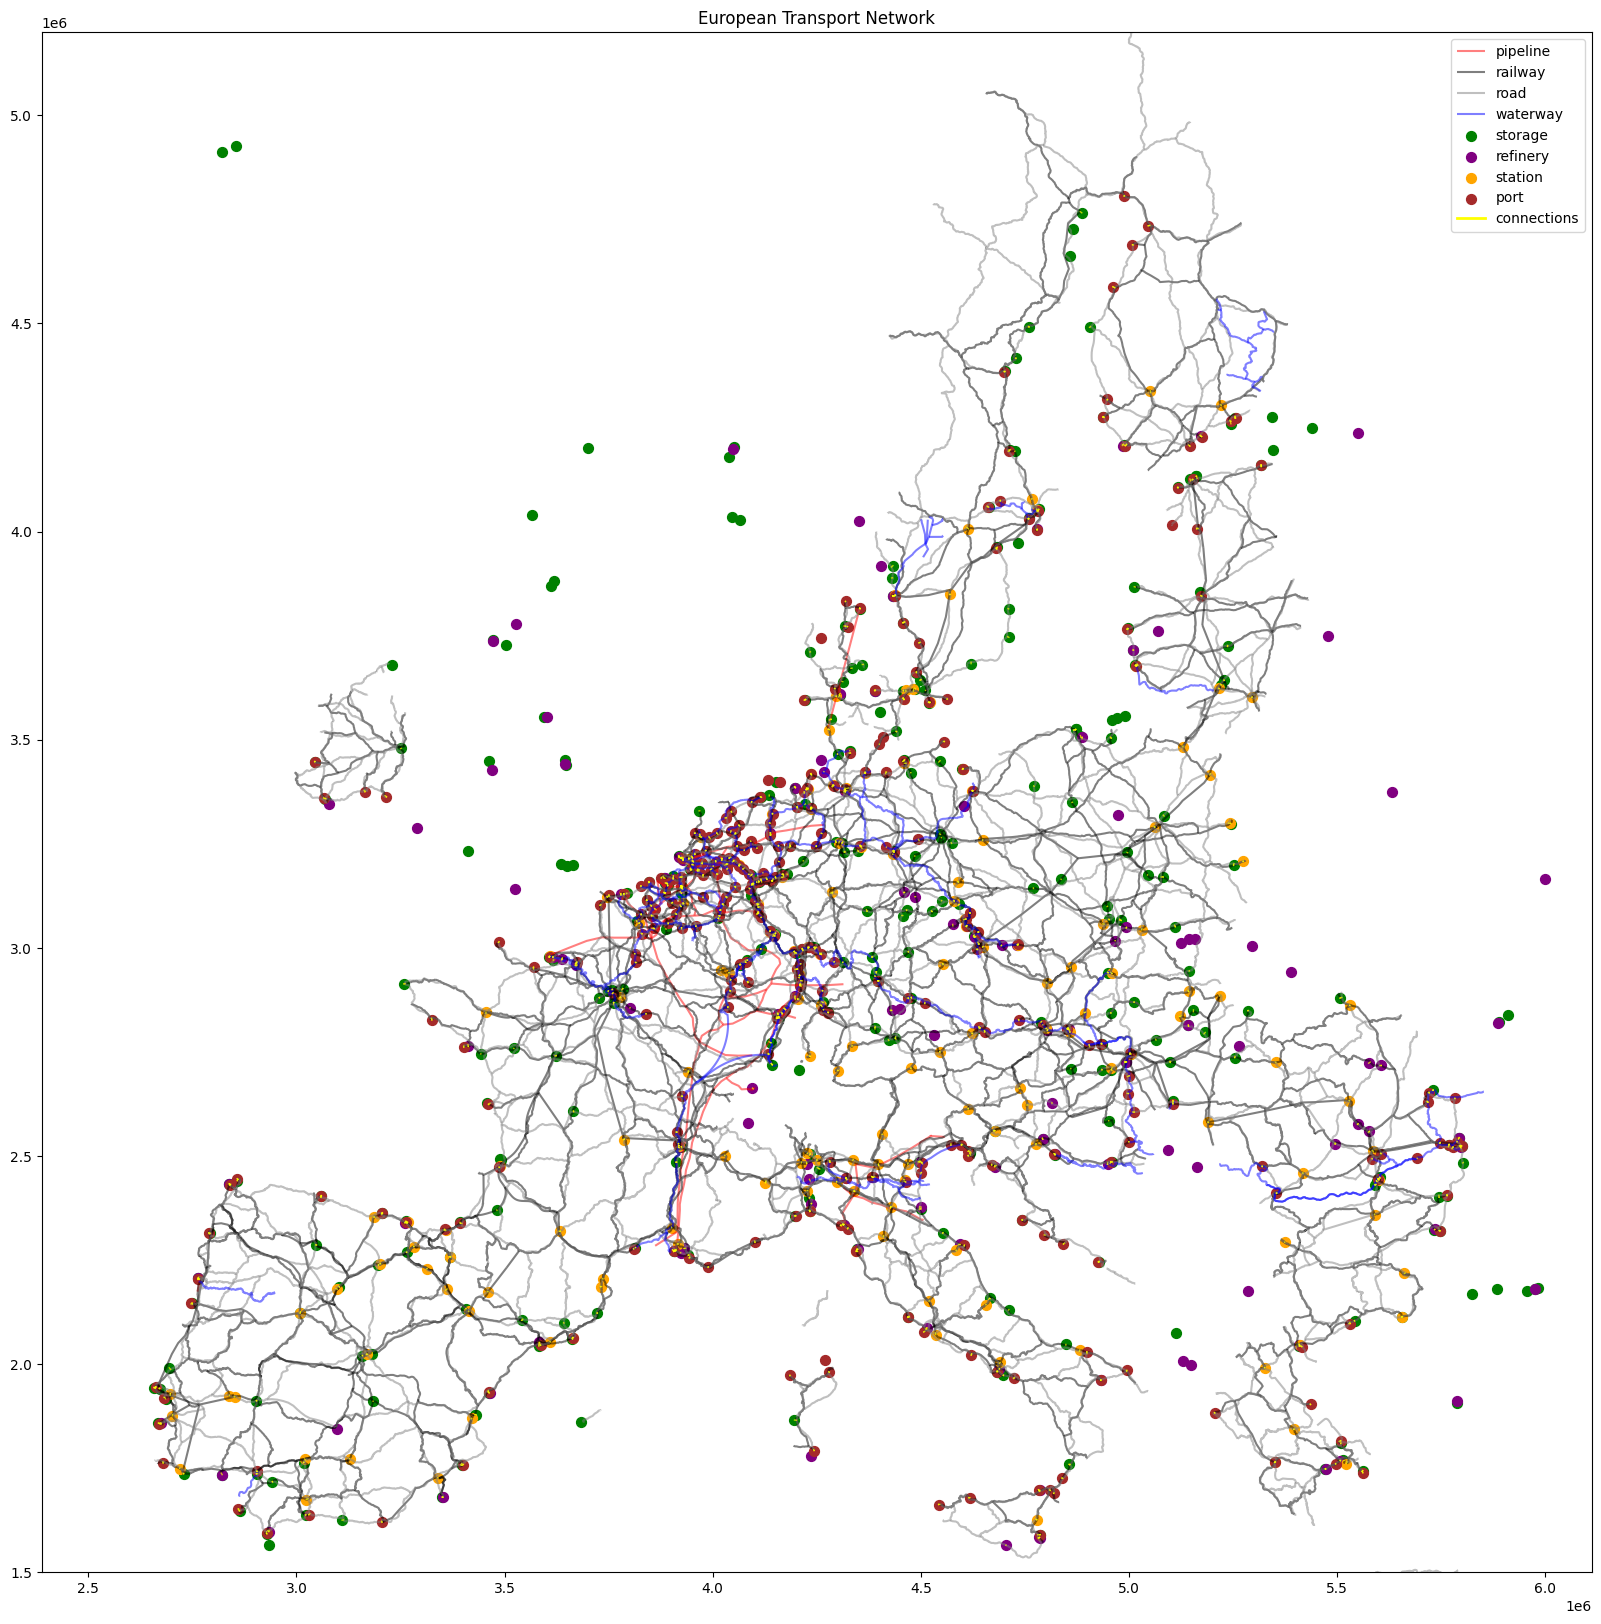

In [5]:
def plot_europe_network():
    europe_bounds = {
        'minx': 2500000, 'maxx': 6000000,
        'miny': 1500000, 'maxy': 5200000
    }
    
    bounded_facilities = merged_facilities[
        (merged_facilities.geometry.x >= europe_bounds['minx']) &
        (merged_facilities.geometry.x <= europe_bounds['maxx']) &
        (merged_facilities.geometry.y >= europe_bounds['miny']) &
        (merged_facilities.geometry.y <= europe_bounds['maxy'])
    ]
    
    bounded_networks = {}
    for mode, network in networks.items():
        bounds = network.geometry.bounds
        bounded_networks[mode] = network[
            (bounds.maxx >= europe_bounds['minx']) &
            (bounds.minx <= europe_bounds['maxx']) &
            (bounds.maxy >= europe_bounds['miny']) &
            (bounds.miny <= europe_bounds['maxy'])
        ]
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    colors = {'pipeline': 'red', 'railway': 'black', 'road': 'gray', 'waterway': 'blue'}
    for mode, network in bounded_networks.items():
        network.plot(ax=ax, color=colors[mode], alpha=0.5, label=mode)
    
    facility_colors = {'storage': 'green', 'refinery': 'purple', 'station': 'orange', 'port': 'brown'}
    for ftype, color in facility_colors.items():
        mask = bounded_facilities['facility_type'] == ftype
        bounded_facilities[mask].plot(ax=ax, color=color, marker='o', markersize=50, label=ftype)
    
    for _, facility in bounded_facilities.iterrows():
        if facility['connections']:
            for conn in facility['connections']:
                plt.plot(*conn.xy, color='yellow', linewidth=1, alpha=0.7)
    plt.plot([], [], color='yellow', label='connections', linewidth=2)
    
    plt.legend()
    plt.title('European Transport Network')
    plt.axis('equal')
    plt.xlim(europe_bounds['minx'], europe_bounds['maxx'])
    plt.ylim(europe_bounds['miny'], europe_bounds['maxy'])
    plt.show()

plot_europe_network()

Het netwerk heeft nog een tweetal problemen: enerzijds dat er delen nog niet verbonden zijn maar dit kan via networkX worden opgelost. Als tweede moet er een verdeling worden gemaakt van hoeveel brandstof/olie opgeslagen ligt op strategische locaties met de vraag of hier voldoende beschikbaar is. Hier moeten de luchthavens ook nog bij. 

laten we zeggen dat ieder land 60 dagen aan brandstofvoorziening heeft.

Dan zijn er twee typen: olie en bewerkte olie.
    Dit moet worden uitgesplitst omdat er meerdere vraagstukken zijn korte termijn en lange termijn vraagstukken. Als je je richt op korte termijn moet je kijken naar kerosine en productiecapaciteit. Bij vraagstukken op de langere termijn moet je kijken naar oliereserves.

    Periodes onder de 4 maanden zijn alleen maar brandstoffen nodig die al bewerkt zijn en extra geproduceerd worden.

61 days of consumption. (if this condition is met)

https://fuelseurope.eu/uploads/files/modules/publications/1689693562_DEF_2023_FE_2023SR_LR.pdf

https://indexmundi.com/energy/?product=jet-fuel&graph=consumption&display=rank

http://www.brrg.de/database.php?language=en&cId=2&dId=146



In [6]:
european_storage = {
    'United Kingdom': round(242.00 * 61, 2),
    'Germany': round(187.00 * 61, 2),
    'France': round(146.00 * 61, 2),
    'Spain': round(114.00 * 61, 2),
    'Italy': round(82.00 * 61, 2),
    'Netherlands': round(72.00 * 61, 2),
    'Switzerland': round(34.00 * 61, 2),
    'Turkey': round(30.00 * 61, 2),
    'Belgium': round(29.00 * 61, 2),
    'Portugal': round(22.00 * 61, 2),
    'Greece': round(21.00 * 61, 2),
    'Sweden': round(18.00 * 61, 2),
    'Denmark': round(18.00 * 61, 2),
    'Belarus': round(18.00 * 61, 2),
    'Austria': round(15.00 * 61, 2),
    'Finland': round(15.00 * 61, 2),
    'Lithuania': round(14.00 * 61, 2),
    'Poland': round(12.00 * 61, 2),
    'Ireland': round(12.00 * 61, 2),
    'Luxembourg': round(7.80 * 61, 2),
    'Czech Republic': round(6.50 * 61, 2),
    'Ukraine': round(6.20 * 61, 2),
    'Bulgaria': round(3.70 * 61, 2),
    'Hungary': round(3.60 * 61, 2),
    'Romania': round(3.00 * 61, 2),
    'Croatia': round(2.50 * 61, 2),
    'Latvia': round(2.50 * 61, 2),
    'Malta': round(2.20 * 61, 2),
    'Serbia': round(1.60 * 61, 2),
    'Slovakia': round(0.80 * 61, 2),
    'Estonia': round(0.80 * 61, 2),
    'Slovenia': round(0.50 * 61, 2),
    'Moldova': round(0.30 * 61, 2),
    'Montenegro': round(0.30 * 61, 2),
    'Bosnia and Herzegovina': round(0.10 * 61, 2)
}

print(f"Total European storage requirement: {sum(european_storage.values()):.2f} thousand barrels")

# https://www.indexmundi.com/energy/?product=oil&graph=consumption&display=rank

Total European storage requirement: 69747.40 thousand barrels


In [7]:
# First get count of storage facilities per country
storage_counts = merged_facilities[
    (merged_facilities['facility_type'] == 'storage') & 
    (merged_facilities['MD_Country'].isin(european_storage.keys()))
].groupby('MD_Country').size()

# Calculate storage needed per facility
storage_per_facility = {}
for country in european_storage.keys():
    if country in storage_counts:
        required_storage = european_storage[country]
        num_facilities = storage_counts[country]
        storage_per_facility[country] = {
            'total_required': required_storage,
            'num_facilities': num_facilities,
            'storage_per_facility': round(required_storage / num_facilities, 2)
        }
    else:
        print(f"Warning: No storage facilities found in {country}")

# Print results
print("\nStorage Requirements per Facility (thousand barrels):")
print("-" * 60)
for country, data in storage_per_facility.items():
    print(f"{country}:")
    print(f"  Total required: {data['total_required']:,.2f}")
    print(f"  Number of facilities: {data['num_facilities']}")
    print(f"  Per facility: {data['storage_per_facility']:,.2f}")
    print()
    


Storage Requirements per Facility (thousand barrels):
------------------------------------------------------------
United Kingdom:
  Total required: 14,762.00
  Number of facilities: 15
  Per facility: 984.13

Germany:
  Total required: 11,407.00
  Number of facilities: 63
  Per facility: 181.06

France:
  Total required: 8,906.00
  Number of facilities: 28
  Per facility: 318.07

Spain:
  Total required: 6,954.00
  Number of facilities: 37
  Per facility: 187.95

Italy:
  Total required: 5,002.00
  Number of facilities: 20
  Per facility: 250.10

Netherlands:
  Total required: 4,392.00
  Number of facilities: 15
  Per facility: 292.80

Switzerland:
  Total required: 2,074.00
  Number of facilities: 1
  Per facility: 2,074.00

Turkey:
  Total required: 1,830.00
  Number of facilities: 14
  Per facility: 130.71

Belgium:
  Total required: 1,769.00
  Number of facilities: 8
  Per facility: 221.12

Portugal:
  Total required: 1,342.00
  Number of facilities: 8
  Per facility: 167.75

Gre

In [8]:
# 2023 capacity data with multiple units
capacity_data = {
    'Austria': {'kbbl_cd': 203.9, 'mt_y': 10.2},
    'Belgium': {'kbbl_cd': 673.7, 'mt_y': 33.7},
    'Bulgaria': {'kbbl_cd': 121.3, 'mt_y': 6.1},
    'Croatia': {'kbbl_cd': 94.9, 'mt_y': 4.7},
    'Czech Republic': {'kbbl_cd': 166.0, 'mt_y': 8.4},
    'Denmark': {'kbbl_cd': 182.5, 'mt_y': 9.1},
    'Finland': {'kbbl_cd': 215.8, 'mt_y': 10.8},
    'France': {'kbbl_cd': 1226.8, 'mt_y': 61.7},
    'Germany': {'kbbl_cd': 2190.6, 'mt_y': 109.5},
    'Greece': {'kbbl_cd': 524.0, 'mt_y': 26.2},
    'Hungary': {'kbbl_cd': 162.0, 'mt_y': 8.1},
    'Ireland': {'kbbl_cd': 75.0, 'mt_y': 3.8},
    'Italy': {'kbbl_cd': 1752.0, 'mt_y': 88.7},
    'Lithuania': {'kbbl_cd': 204.0, 'mt_y': 10.2},
    'Netherlands': {'kbbl_cd': 1277.9, 'mt_y': 65.4},
    'Poland': {'kbbl_cd': 622.0, 'mt_y': 31.2},
    'Portugal': {'kbbl_cd': 237.9, 'mt_y': 11.9},
    'Romania': {'kbbl_cd': 250.5, 'mt_y': 12.5},
    'Slovakia': {'kbbl_cd': 112.0, 'mt_y': 5.6},
    'Spain': {'kbbl_cd': 1505.7, 'mt_y': 75.4},
    'Sweden': {'kbbl_cd': 462.6, 'mt_y': 23.2}
}

# Get count of refineries per country
refinery_counts = merged_facilities[
    merged_facilities['facility_type'] == 'refinery'
].groupby('MD_Country').size()

# Calculate capacity per refinery for each country
country_capacities = {}
for country, count in refinery_counts.items():
    if country in capacity_data:
        capacity_per_refinery = {
            'kbbl_cd': capacity_data[country]['kbbl_cd'] / count,
            'mt_y': capacity_data[country]['mt_y'] / count
        }
        country_capacities[country] = capacity_per_refinery

# Add capacity columns to merged_facilities
merged_facilities['refinery_capacity_kbbl_cd'] = 0.0  # thousand barrels per calendar day
merged_facilities['refinery_capacity_mt_y'] = 0.0     # million tonnes per year
refinery_mask = merged_facilities['facility_type'] == 'refinery'

# Assign capacities to refineries
for country, capacity in country_capacities.items():
    country_mask = merged_facilities['MD_Country'] == country
    merged_facilities.loc[refinery_mask & country_mask, 'refinery_capacity_kbbl_cd'] = capacity['kbbl_cd']
    merged_facilities.loc[refinery_mask & country_mask, 'refinery_capacity_mt_y'] = capacity['mt_y']

print("\nRefinery capacities added to merged_facilities DataFrame")
print("\nSample of refinery capacities by country:")
capacity_summary = merged_facilities[refinery_mask].groupby('MD_Country').agg({
    'refinery_capacity_kbbl_cd': ['count', 'mean', 'sum'],
    'refinery_capacity_mt_y': ['mean', 'sum']
})
print("\nCapacities:")
for country in capacity_summary.index:
    print(f"\n{country}:")
    count = capacity_summary.loc[country, ('refinery_capacity_kbbl_cd', 'count')]
    kbbl_mean = capacity_summary.loc[country, ('refinery_capacity_kbbl_cd', 'mean')]
    mt_mean = capacity_summary.loc[country, ('refinery_capacity_mt_y', 'mean')]
    kbbl_total = capacity_summary.loc[country, ('refinery_capacity_kbbl_cd', 'sum')]
    mt_total = capacity_summary.loc[country, ('refinery_capacity_mt_y', 'sum')]
    print(f"  Number of refineries: {count}")
    print(f"  Per refinery: {kbbl_mean:.1f} kbbl/cd ({mt_mean:.1f} Mt/y)")
    print(f"  Total capacity: {kbbl_total:.1f} kbbl/cd ({mt_total:.1f} Mt/y)")


Refinery capacities added to merged_facilities DataFrame

Sample of refinery capacities by country:

Capacities:

Albania:
  Number of refineries: 2
  Per refinery: 0.0 kbbl/cd (0.0 Mt/y)
  Total capacity: 0.0 kbbl/cd (0.0 Mt/y)

Australia:
  Number of refineries: 6
  Per refinery: 0.0 kbbl/cd (0.0 Mt/y)
  Total capacity: 0.0 kbbl/cd (0.0 Mt/y)

Austria:
  Number of refineries: 1
  Per refinery: 203.9 kbbl/cd (10.2 Mt/y)
  Total capacity: 203.9 kbbl/cd (10.2 Mt/y)

Azerbaijan:
  Number of refineries: 1
  Per refinery: 0.0 kbbl/cd (0.0 Mt/y)
  Total capacity: 0.0 kbbl/cd (0.0 Mt/y)

Belarus:
  Number of refineries: 2
  Per refinery: 0.0 kbbl/cd (0.0 Mt/y)
  Total capacity: 0.0 kbbl/cd (0.0 Mt/y)

Belgium:
  Number of refineries: 1
  Per refinery: 673.7 kbbl/cd (33.7 Mt/y)
  Total capacity: 673.7 kbbl/cd (33.7 Mt/y)

Bulgaria:
  Number of refineries: 1
  Per refinery: 121.3 kbbl/cd (6.1 Mt/y)
  Total capacity: 121.3 kbbl/cd (6.1 Mt/y)

Croatia:
  Number of refineries: 4
  Per refinery: 

In [9]:
# https://www.nato.int/nato-on-the-map/#lat=48.3499986&lon=19.3166654&zoom=1&layer-5&infoBox=847


Onderstaand is het inladen van data over 

In [10]:
#https://www.iea.org/data-and-statistics/data-tools/oil-stocks-of-iea-countries


Hieronder komt simpeler aanklooien met road network.


In [12]:
from shapely.geometry import Point, MultiPoint, LineString
from shapely.ops import split, unary_union
import networkx as nx
import geopandas as gpd

def build_intersection_graph(gdf):
    G = nx.Graph()
    lines = []
    
    # Convert to LineStrings
    for _, row in gdf.iterrows():
        if row.geometry.geom_type == 'MultiLineString':
            lines.extend(list(row.geometry.geoms))
        else:
            lines.append(row.geometry)
    
    # Find intersections
    intersections = []
    for i, line1 in enumerate(lines):
        for line2 in lines[i+1:]:
            if line1.intersects(line2):
                point = line1.intersection(line2)
                if isinstance(point, Point):
                    intersections.append(point)
    
    # Add edges with intersections
    for line in lines:
        split_points = [p for p in intersections if line.intersects(p)]
        if split_points:
            try:
                result = split(line, MultiPoint(split_points))
                if isinstance(result, LineString):
                    segments = [result]
                else:
                    segments = list(result.geoms)
                for segment in segments:
                    G.add_edge(segment.coords[0], segment.coords[-1])
            except:
                # If splitting fails, add original line
                G.add_edge(line.coords[0], line.coords[-1])
    
    return G

G = build_intersection_graph(networks['road'])
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")



Nodes: 2761
Edges: 3328


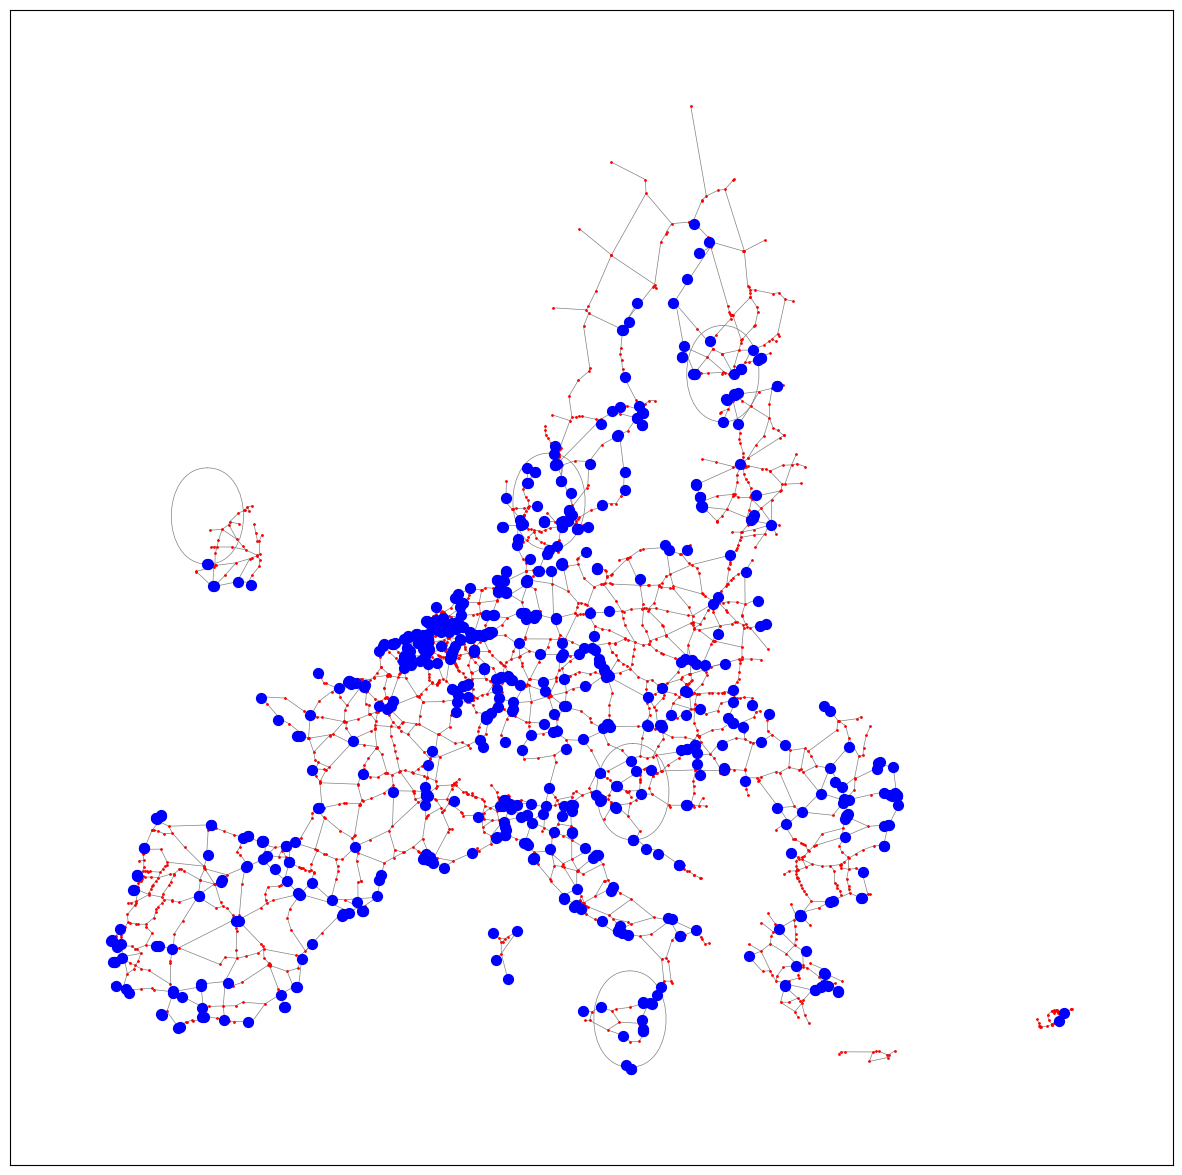

Total nodes: 3436
Facility nodes: 679
Road nodes: 2757
Total edges: 4007


In [13]:
def connect_road_facilities(G_original, facilities_gdf):
    G = G_original.copy()
    
    # Only process facilities with road connections
    for idx, facility in facilities_gdf.iterrows():
        if facility['connections'] and len(facility['connections']) > 0:
            connection_modes = [conn['mode'] for conn in facility['connection_distances']]
            if 'road' in connection_modes:
                facility_coord = (facility.geometry.x, facility.geometry.y)
                
                # Find closest existing road node
                min_dist = float('inf')
                closest_node = None
                for node in G_original.nodes():
                    dist = ((node[0] - facility_coord[0])**2 + (node[1] - facility_coord[1])**2)**0.5
                    if dist < min_dist:
                        min_dist = dist
                        closest_node = node
                
                # Add facility node and connect to closest road node
                G.add_node(facility_coord, 
                          type='facility',
                          facility_type=facility['facility_type'],
                          capacity=facility['Capacity'])
                G.add_edge(facility_coord, closest_node, 
                          type='facility_connection',
                          distance=min_dist)
    
    return G

# Create network with facilities connected
G = connect_road_facilities(G, merged_facilities)

# Visualize
plt.figure(figsize=(15,15))
pos = {node: node for node in G.nodes()}

# Draw all edges
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5)

# Draw nodes with different colors based on type
facility_nodes = [n for n,attr in G.nodes(data=True) if attr.get('type')=='facility']
road_nodes = [n for n,attr in G.nodes(data=True) if attr.get('type')!='facility']

nx.draw_networkx_nodes(G, pos, nodelist=road_nodes, node_size=1, node_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=facility_nodes, node_size=50, node_color='blue')

plt.axis('equal')
plt.show()

print(f"Total nodes: {G.number_of_nodes()}")
print(f"Facility nodes: {len(facility_nodes)}")
print(f"Road nodes: {len(road_nodes)}")
print(f"Total edges: {G.number_of_edges()}")



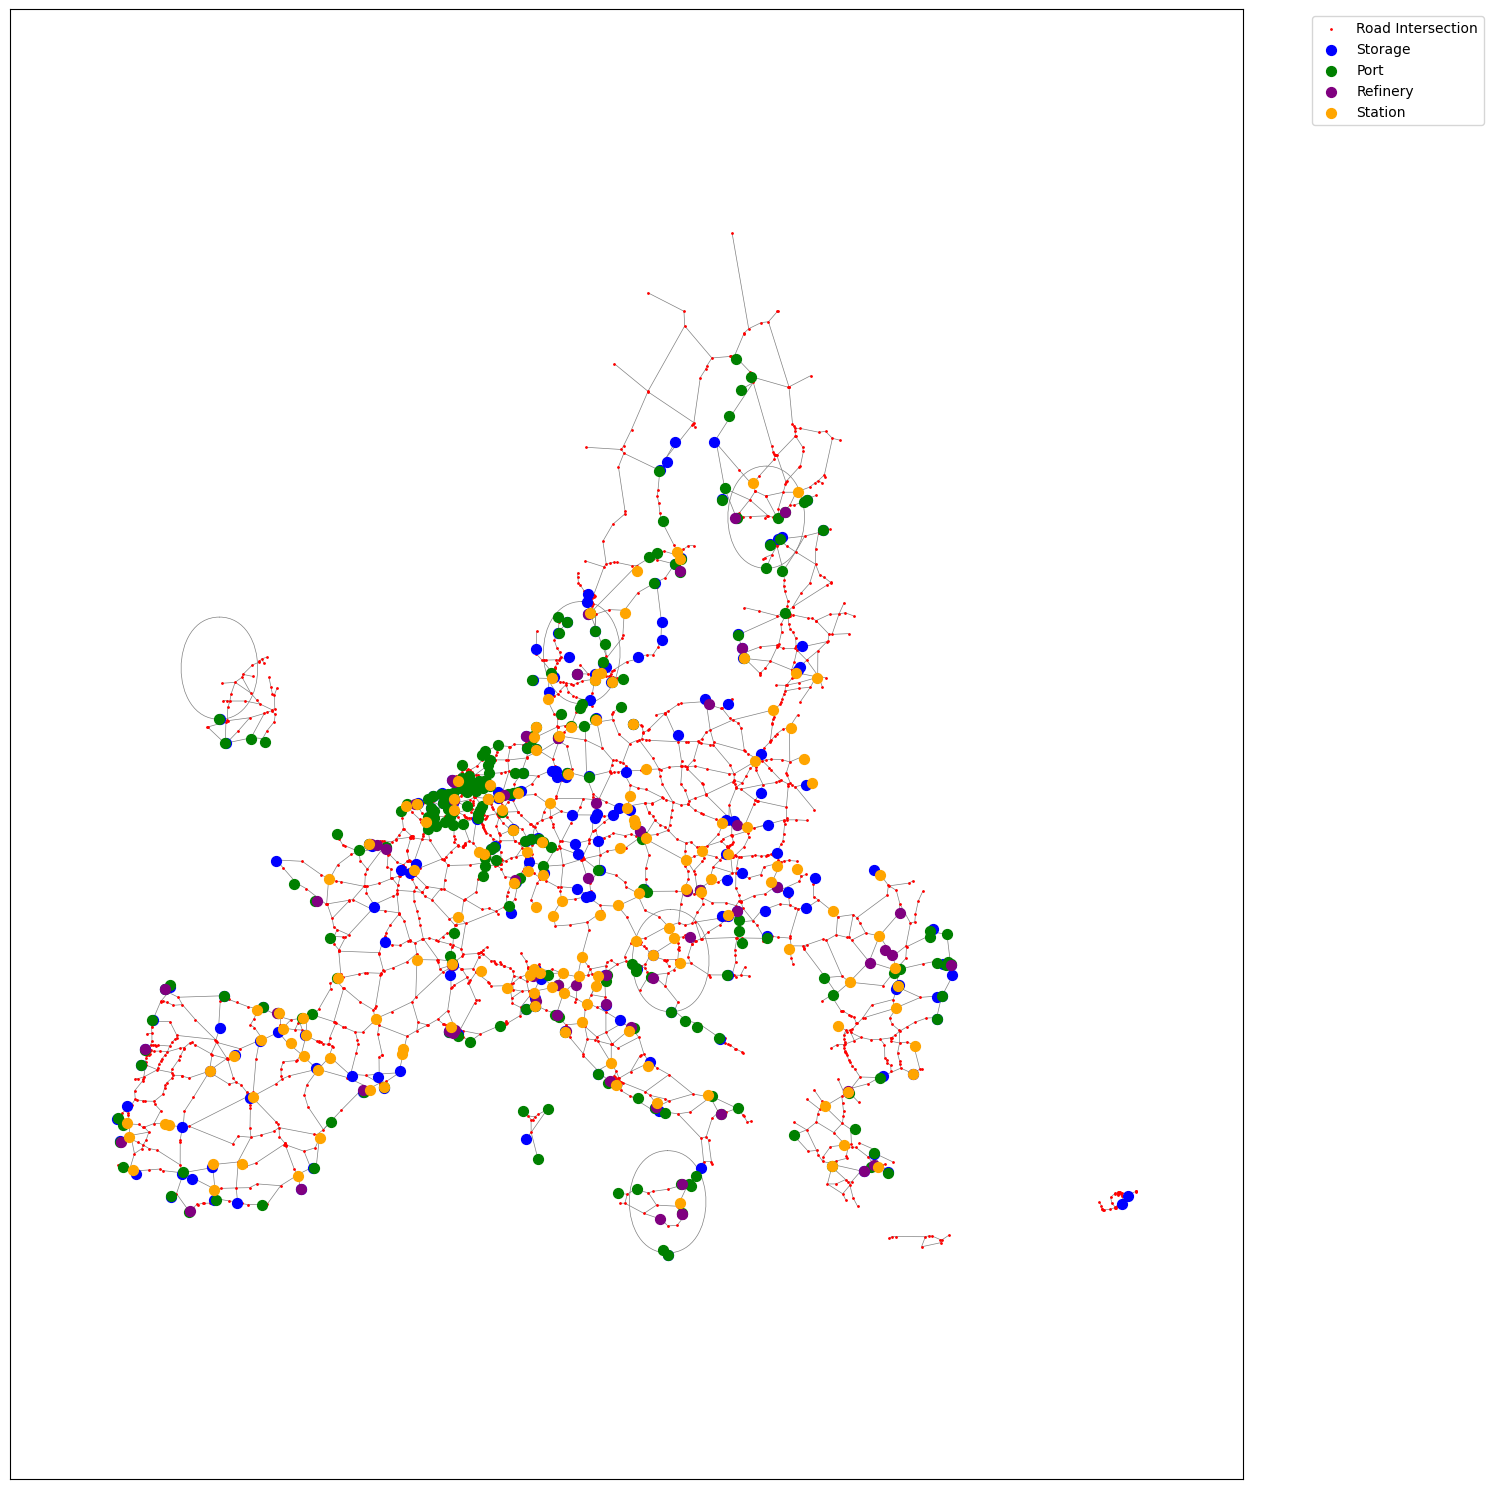

Storage: 215 facilities
Port: 245 facilities
Refinery: 64 facilities
Station: 155 facilities


In [14]:
plt.figure(figsize=(15,15))
pos = {node: node for node in G.nodes()}

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5)

# Draw road nodes
road_nodes = [n for n,attr in G.nodes(data=True) if attr.get('type')!='facility']
nx.draw_networkx_nodes(G, pos, nodelist=road_nodes, node_size=1, node_color='red', label='Road Intersection')

# Draw different facility types with different colors
colors = {'storage': 'blue', 'port': 'green', 'refinery': 'purple', 'station': 'orange'}
for facility_type, color in colors.items():
   nodes = [n for n,attr in G.nodes(data=True) 
            if attr.get('type')=='facility' and attr.get('facility_type')==facility_type]
   if nodes:  # Only draw if we have facilities of this type
       nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=50, 
                            node_color=color, label=facility_type.capitalize())

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print statistics
for facility_type in colors.keys():
   count = len([n for n,attr in G.nodes(data=True) 
               if attr.get('type')=='facility' and attr.get('facility_type')==facility_type])
   print(f"{facility_type.capitalize()}: {count} facilities")

   

Rail network - Nodes: 2853, Edges: 3732


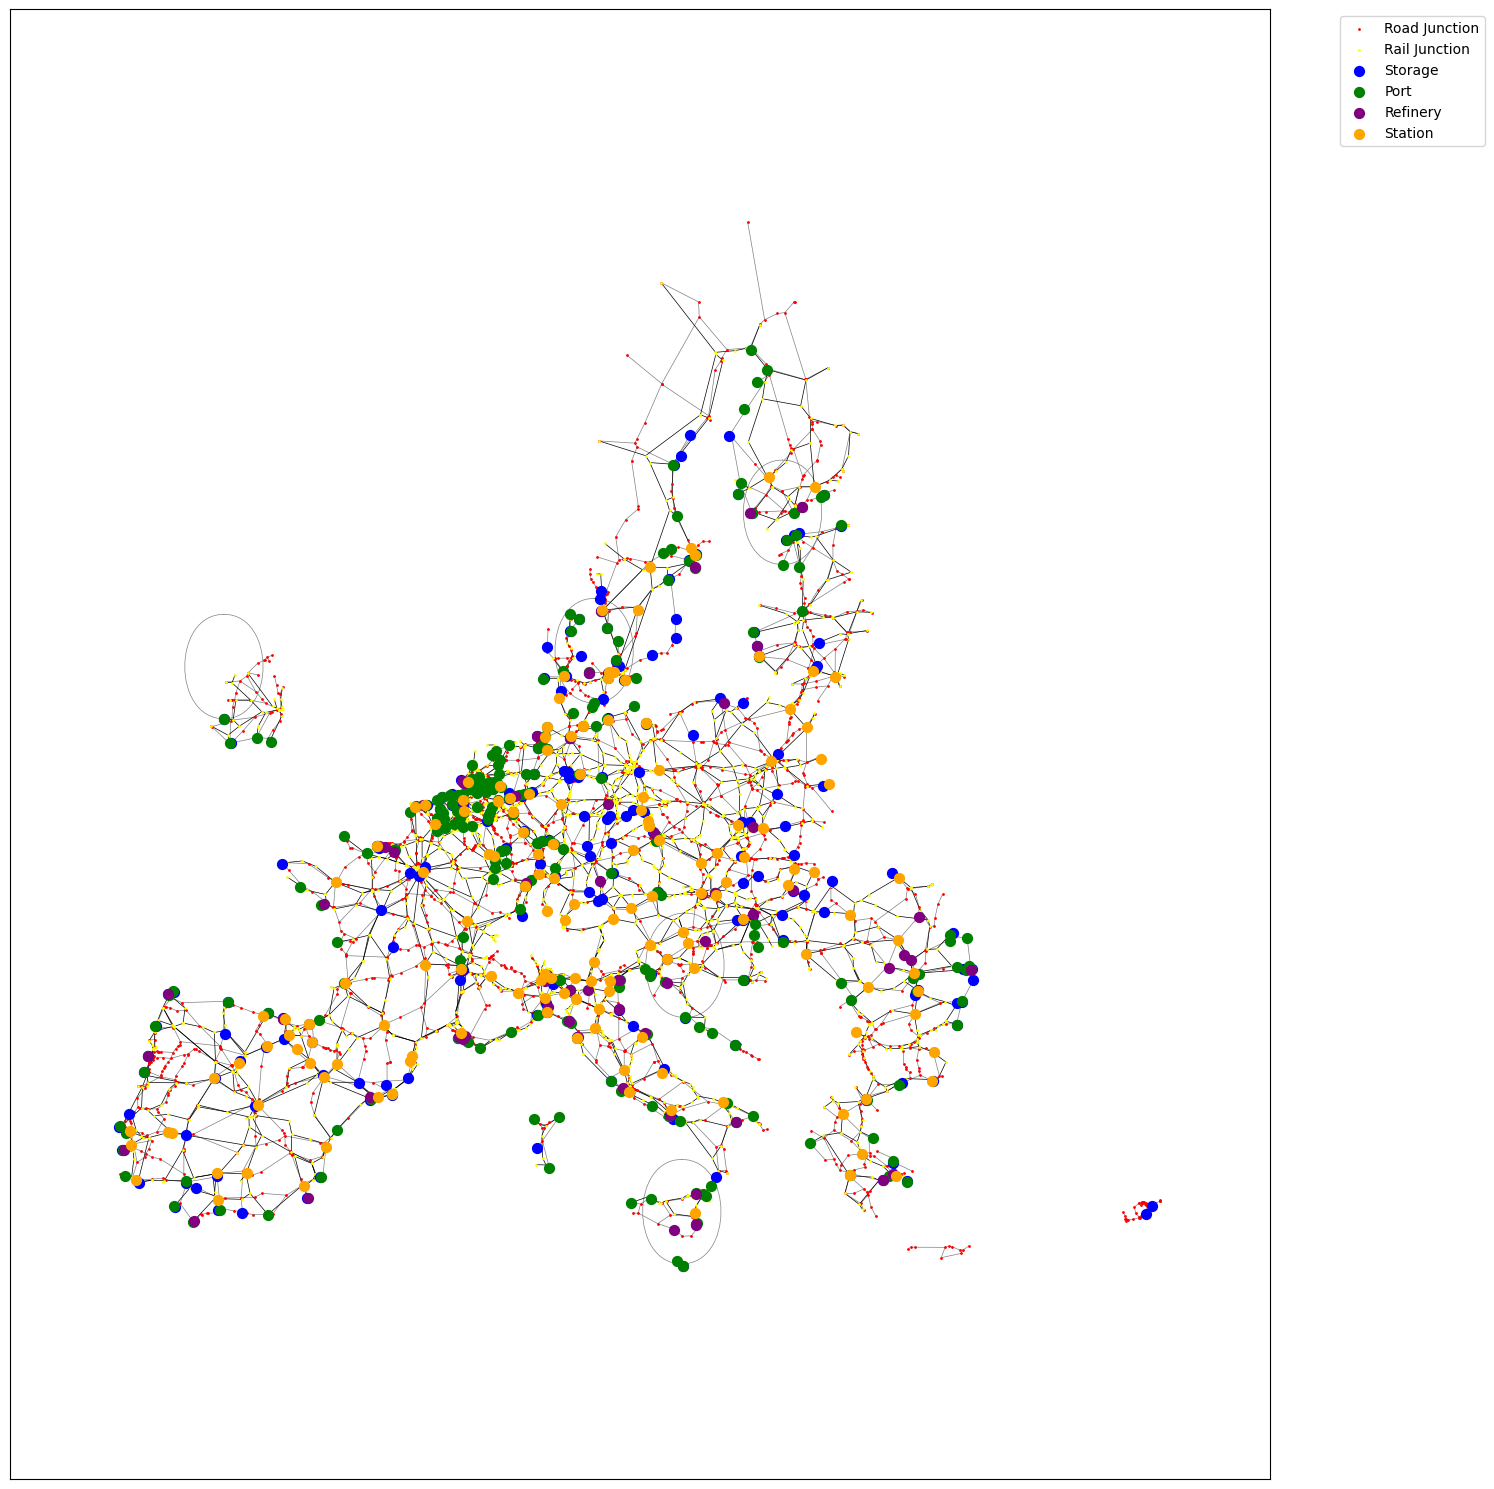

In [15]:
# Build rail network similar to road
G_rail = build_intersection_graph(networks['railway'])
print(f"Rail network - Nodes: {G_rail.number_of_nodes()}, Edges: {G_rail.number_of_edges()}")

# Visualize both networks
plt.figure(figsize=(15,15))

# Draw roads in one color
pos_road = {node: node for node in G.nodes()}
nx.draw_networkx_edges(G, pos_road, edge_color='gray', width=0.5)
road_nodes = [n for n,attr in G.nodes(data=True) if attr.get('type')!='facility']
nx.draw_networkx_nodes(G, pos_road, nodelist=road_nodes, node_size=1, node_color='red', label='Road Junction')

# Draw rail in another color
pos_rail = {node: node for node in G_rail.nodes()}
nx.draw_networkx_edges(G_rail, pos_rail, edge_color='black', width=0.5)
nx.draw_networkx_nodes(G_rail, pos_rail, node_size=1, node_color='yellow', label='Rail Junction')

# Draw facilities
colors = {'storage': 'blue', 'port': 'green', 'refinery': 'purple', 'station': 'orange'}
for facility_type, color in colors.items():
    nodes = [n for n,attr in G.nodes(data=True) 
             if attr.get('type')=='facility' and attr.get('facility_type')==facility_type]
    if nodes:
        nx.draw_networkx_nodes(G, pos_road, nodelist=nodes, node_size=50, 
                             node_color=color, label=facility_type.capitalize())

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()


Pipeline network - Nodes: 46, Edges: 48


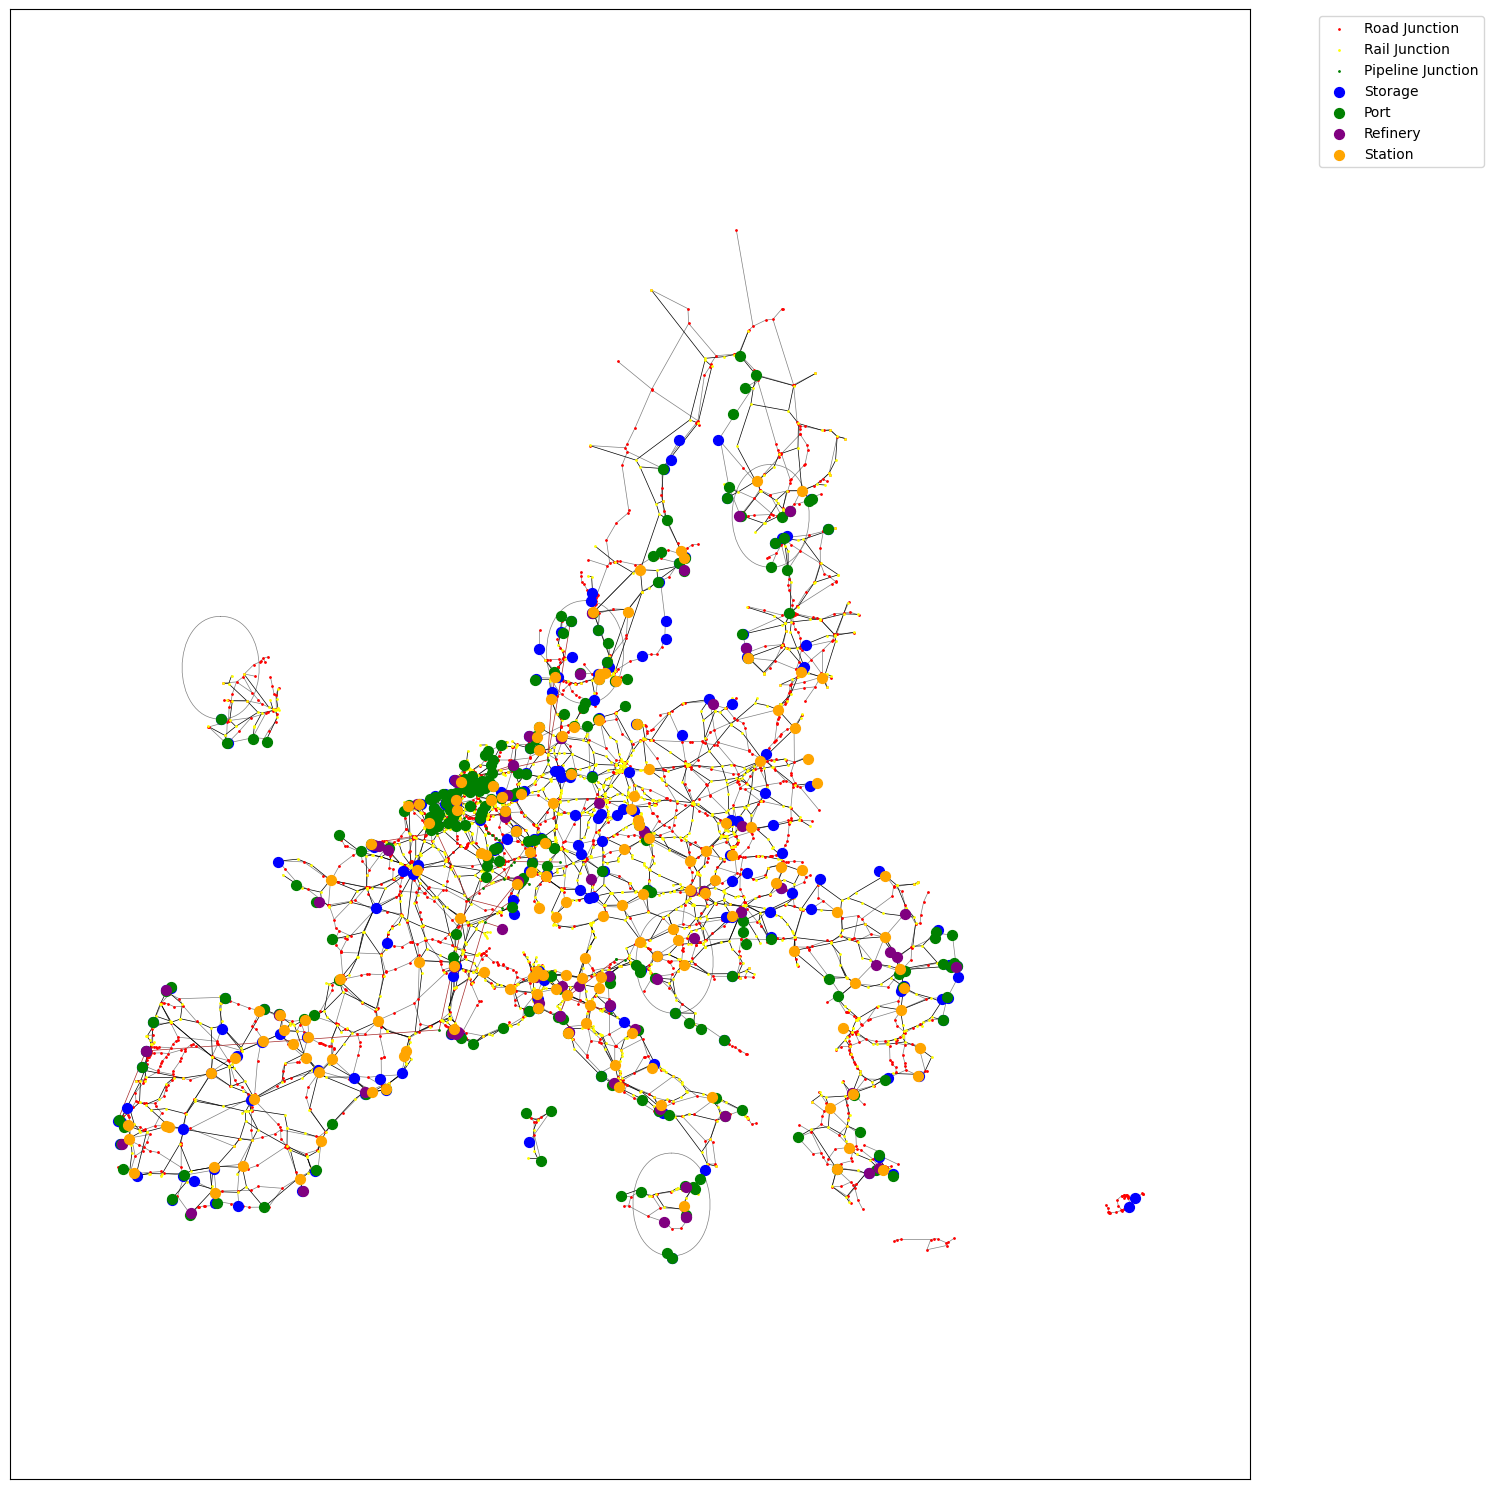

In [16]:
def build_intersection_graph(gdf):
   G = nx.Graph()
   lines = []
   
   # Handle null geometries
   gdf = gdf[gdf.geometry.notna()]
   
   # Convert to LineStrings
   for _, row in gdf.iterrows():
       if row.geometry.geom_type == 'MultiLineString':
           lines.extend(list(row.geometry.geoms))
       else:
           lines.append(row.geometry)
   
   # Find intersections
   intersections = []
   for i, line1 in enumerate(lines):
       for line2 in lines[i+1:]:
           if line1.intersects(line2):
               point = line1.intersection(line2)
               if isinstance(point, Point):
                   intersections.append(point)
   
   # Add edges with intersections
   for line in lines:
       split_points = [p for p in intersections if line.intersects(p)]
       if split_points:
           try:
               result = split(line, MultiPoint(split_points))
               if isinstance(result, LineString):
                   segments = [result]
               else:
                   segments = list(result.geoms)
               for segment in segments:
                   G.add_edge(segment.coords[0], segment.coords[-1])
           except:
               G.add_edge(line.coords[0], line.coords[-1])
   
   return G

# Build networks
G_pipe = build_intersection_graph(networks['pipeline'])
print(f"Pipeline network - Nodes: {G_pipe.number_of_nodes()}, Edges: {G_pipe.number_of_edges()}")

def connect_facilities_to_network(G_pipe, facilities_gdf, mode='pipeline'):
   for idx, facility in facilities_gdf.iterrows():
       if facility['connections'] and len(facility['connections']) > 0:
           connection_modes = [conn['mode'] for conn in facility['connection_distances']]
           if mode in connection_modes:
               facility_coord = (facility.geometry.x, facility.geometry.y)
               
               min_dist = float('inf')
               closest_node = None
               for node in G_pipe.nodes():
                   dist = ((node[0] - facility_coord[0])**2 + (node[1] - facility_coord[1])**2)**0.5
                   if dist < min_dist:
                       min_dist = dist
                       closest_node = node
               
               G_pipe.add_node(facility_coord, 
                         type='facility',
                         facility_type=facility['facility_type'],
                         capacity=facility['Capacity'])
               G_pipe.add_edge(facility_coord, closest_node, 
                         type='facility_connection',
                         mode='pipeline',
                         distance=min_dist)
   return G_pipe

G_pipe = connect_facilities_to_network(G_pipe, merged_facilities)

# Visualize
plt.figure(figsize=(15,15))

pos = {node: node for node in G.nodes()}
pos.update({node: node for node in G_rail.nodes()})
pos.update({node: node for node in G_pipe.nodes()})

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5)
nx.draw_networkx_edges(G_rail, pos, edge_color='black', width=0.5)
nx.draw_networkx_edges(G_pipe, pos, edge_color='brown', width=0.5)

road_nodes = [n for n,attr in G.nodes(data=True) if attr.get('type')!='facility']
rail_nodes = [n for n,attr in G_rail.nodes(data=True) if attr.get('type')!='facility']
pipe_nodes = [n for n,attr in G_pipe.nodes(data=True) if attr.get('type')!='facility']

nx.draw_networkx_nodes(G, pos, nodelist=road_nodes, node_size=1, node_color='red', label='Road Junction')
nx.draw_networkx_nodes(G_rail, pos, nodelist=rail_nodes, node_size=1, node_color='yellow', label='Rail Junction')
nx.draw_networkx_nodes(G_pipe, pos, nodelist=pipe_nodes, node_size=1, node_color='green', label='Pipeline Junction')

colors = {'storage': 'blue', 'port': 'green', 'refinery': 'purple', 'station': 'orange'}
for facility_type, color in colors.items():
   nodes = []
   for G_mode in [G, G_rail, G_pipe]:
       nodes.extend([n for n,attr in G_mode.nodes(data=True) 
                    if attr.get('type')=='facility' and attr.get('facility_type')==facility_type])
   nodes = list(set(nodes))
   if nodes:
       nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=50, 
                            node_color=color, label=facility_type.capitalize())

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [17]:
G_combined = nx.Graph()

# Add infrastructure edges with mode attributes
for u, v in G.edges():
   G_combined.add_edge(u, v, mode='road')
for u, v in G_rail.edges():
   G_combined.add_edge(u, v, mode='railway') 
for u, v in G_pipe.edges():
   G_combined.add_edge(u, v, mode='pipeline')

# Add facilities only once with all their connections
facilities_added = set()
for G_mode, mode in [(G, 'road'), (G_rail, 'railway'), (G_pipe, 'pipeline')]:
   facility_nodes = [(n,attr) for n,attr in G_mode.nodes(data=True) 
                    if attr.get('type')=='facility']
   for n, attr in facility_nodes:
       if n not in facilities_added:
           G_combined.add_node(n, **attr)
           facilities_added.add(n)

# Keep largest component
largest_cc = max(nx.connected_components(G_combined), key=len)
G_combined = G_combined.subgraph(largest_cc).copy()


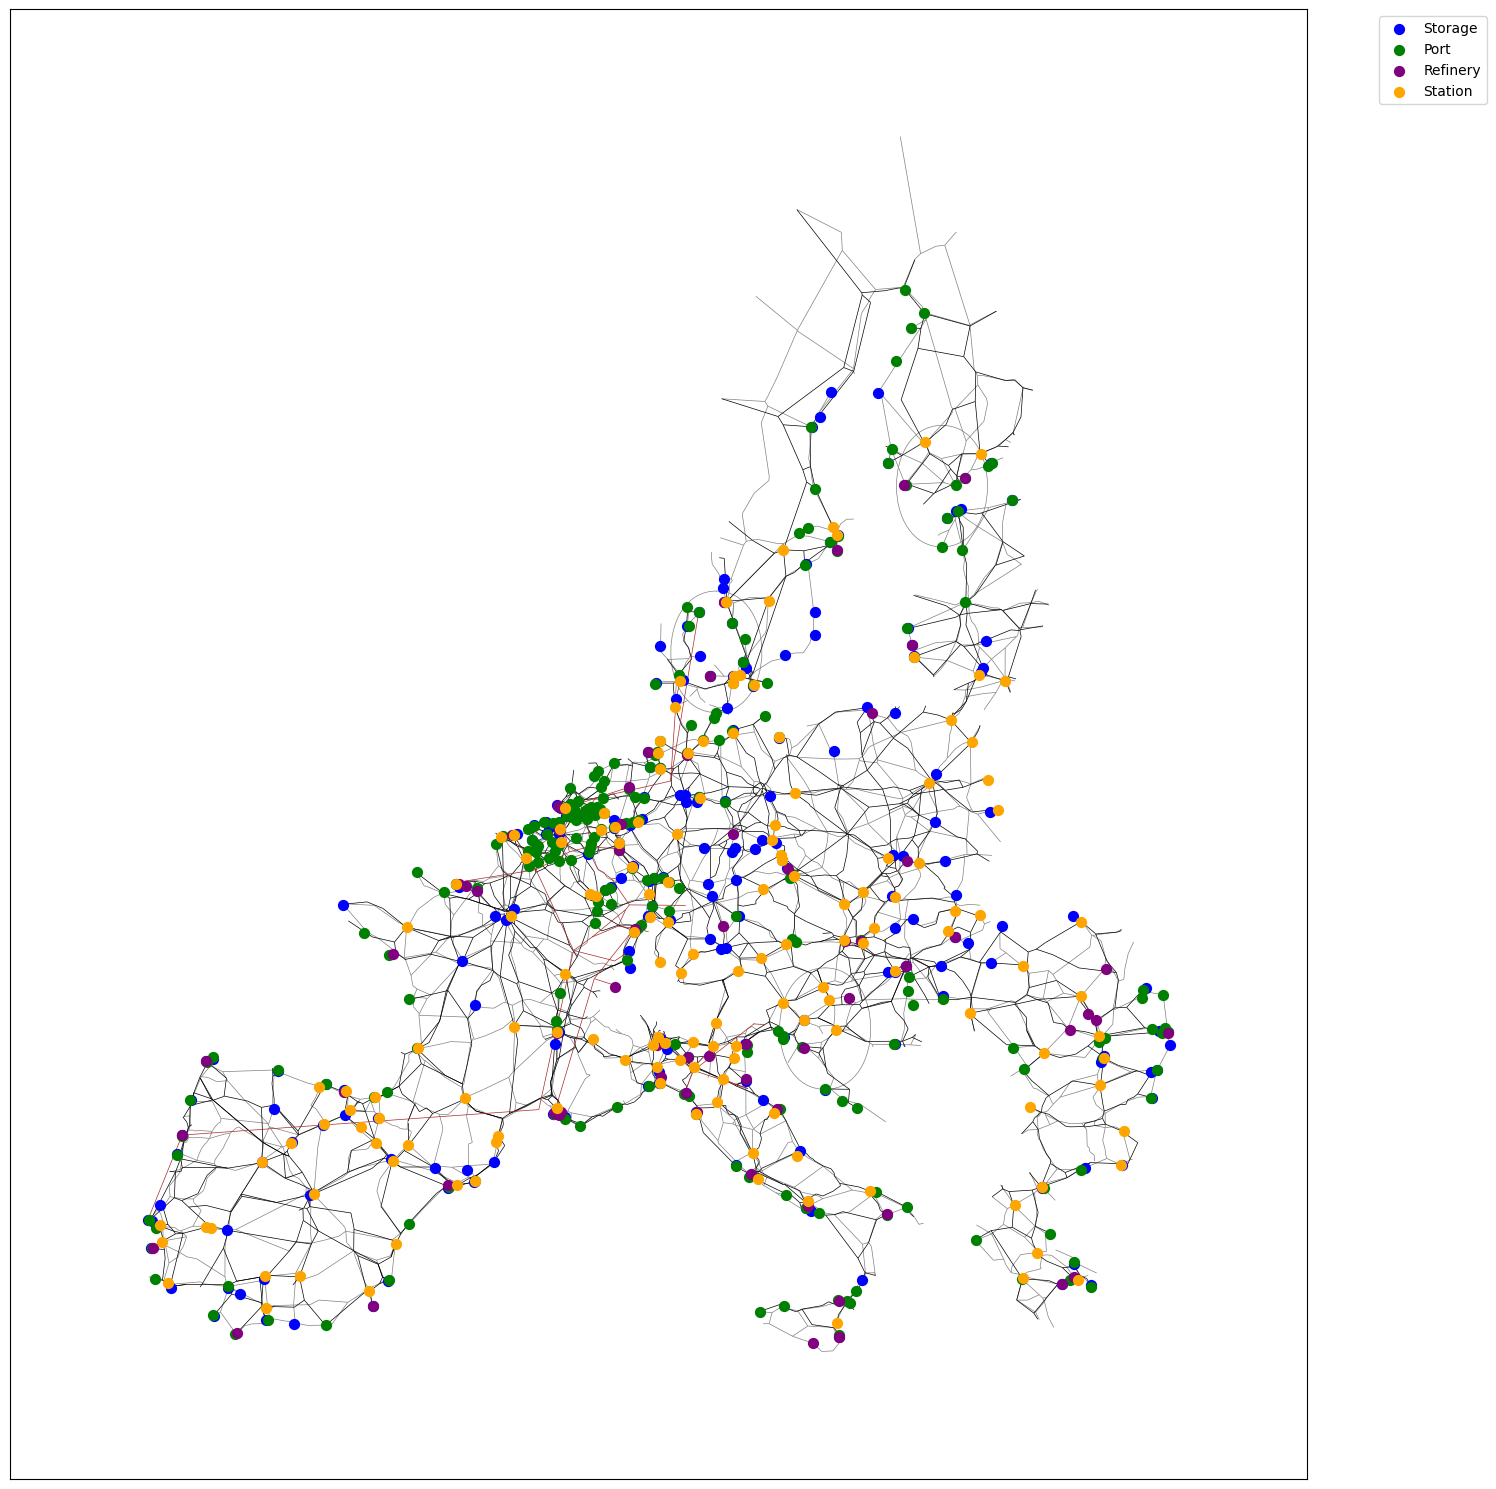

Nodes: 6105
Edges: 7608


In [18]:
plt.figure(figsize=(15,15))
pos = {node: node for node in G_combined.nodes()}

# Draw edges by mode
for mode, color in {'road': 'gray', 'railway': 'black', 'pipeline': 'brown'}.items():
   edges = [(u,v) for (u,v,d) in G_combined.edges(data=True) if d.get('mode')==mode]
   nx.draw_networkx_edges(G_combined, pos, edgelist=edges, edge_color=color, width=0.5)

# Draw facilities
colors = {'storage': 'blue', 'port': 'green', 'refinery': 'purple', 'station': 'orange'}
for facility_type, color in colors.items():
   nodes = [n for n,attr in G_combined.nodes(data=True) 
            if attr.get('type')=='facility' and attr.get('facility_type')==facility_type]
   if nodes:
       nx.draw_networkx_nodes(G_combined, pos, nodelist=nodes, node_size=50, 
                            node_color=color, label=facility_type.capitalize())

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"Nodes: {G_combined.number_of_nodes()}")
print(f"Edges: {G_combined.number_of_edges()}")


Hieronder komt aanklooien met alleen road network.



Hier komt de eerste poging om het werkend te krijgen! Dit was in de avond lang klieren zonder resultaat:


In [22]:
import geopandas as gpd
import networkx as nx

# Read the shapefiles
nuts2_regions = gpd.read_file('./data1/Europe NUTS 2 Demographics and Boundaries.shp')
nuts3_regions = gpd.read_file('./data1/Europe NUTS 3 Demographics and Boundaries.shp')

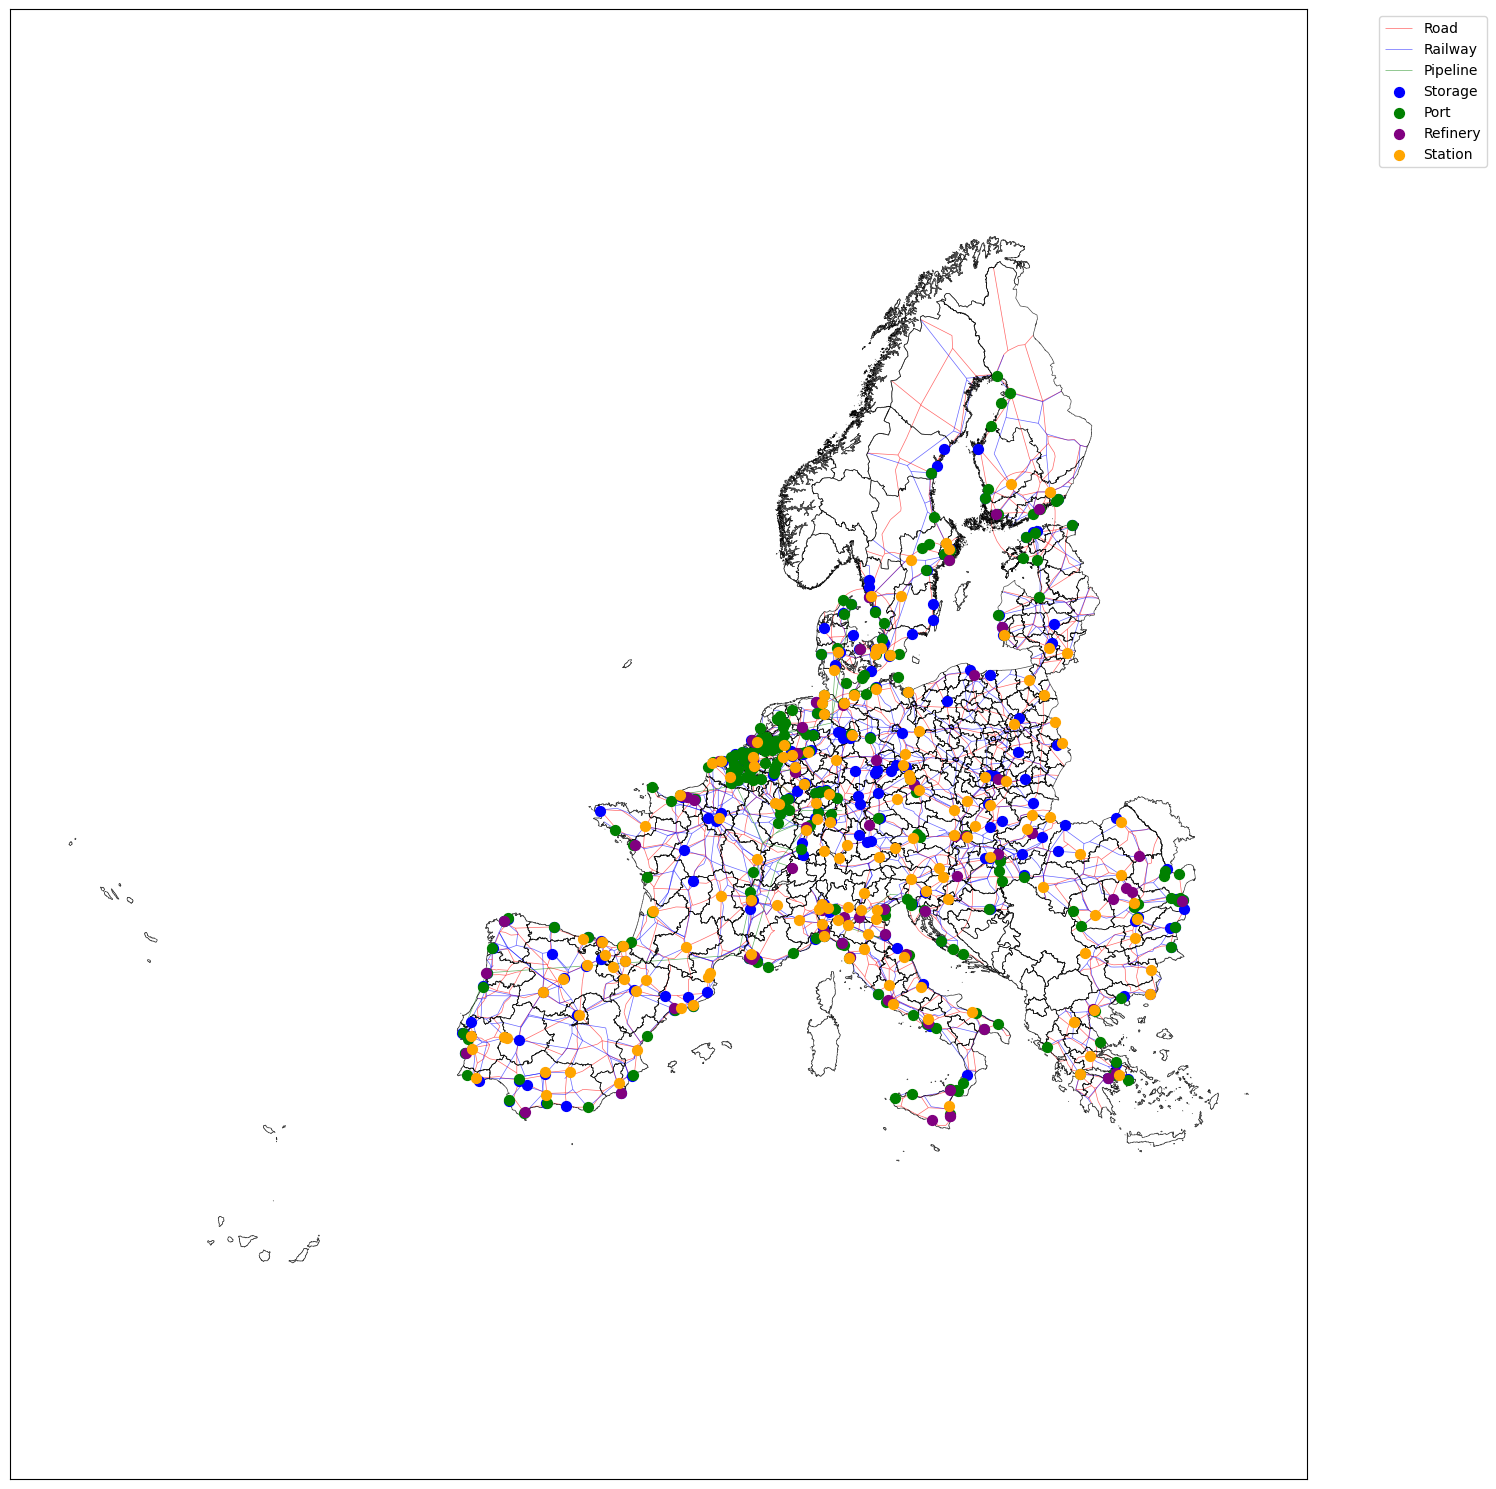

In [40]:


def process_nuts_borders(nuts2_regions, nuts3_regions):
    """
    Process NUTS borders and return the combined GeoDataFrame
    """
    # List of countries to exclude
    excluded_countries = ['UK', 'TR', 'UA', 'IS', 'AZ', 'IE', 'RU','GE','CY','BY']
    
    # List of countries to show in NUTS-3 level
    nuts3_countries = [
        'PL',           # Poland
        'EE', 'LV', 'LT'  # Baltic states
    ]
    
    # Filter NUTS-3 data for Baltic states and Poland
    nuts3_filtered = nuts3_regions[
        nuts3_regions['NUTS0'].isin(nuts3_countries) & 
        ~nuts3_regions['NUTS0'].isin(excluded_countries)
    ]
    
    # Filter NUTS-2 data for remaining countries
    nuts2_filtered = nuts2_regions[
        ~nuts2_regions['NUTS0'].isin(nuts3_countries) & 
        ~nuts2_regions['NUTS0'].isin(excluded_countries)
    ]
    
    # Combine the filtered regions
    combined_nuts = pd.concat([nuts2_filtered, nuts3_filtered])
    
    # Transform to EPSG:3035 projection
    return combined_nuts.to_crs(epsg=3035)

def visualize_network_europe(G_combined, nuts_transformed, figsize=(15, 15)):
    """
    Visualize network with the processed NUTS borders
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot borders with no fill
    nuts_transformed.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
    
    # Draw network edges
    pos = {node: node for node in G_combined.nodes()}
    
    edge_styles = {
        'road': {'color': 'red', 'width': 0.5, 'alpha': 0.6},
        'railway': {'color': 'blue', 'width': 0.5, 'alpha': 0.6},
        'pipeline': {'color': 'green', 'width': 0.5, 'alpha': 0.6}
    }
    
    for mode, style in edge_styles.items():
        mode_edges = [(u, v) for u, v, d in G_combined.edges(data=True) 
                     if d.get('mode') == mode]
        if mode_edges:
            nx.draw_networkx_edges(G_combined, pos, 
                                 edgelist=mode_edges,
                                 edge_color=style['color'],
                                 width=style['width'],
                                 alpha=style['alpha'],
                                 ax=ax,
                                 label=f'{mode.capitalize()}')
    
    # Draw facilities
    facility_styles = {
        'storage': {'color': 'blue', 'size': 50},
        'port': {'color': 'green', 'size': 50},
        'refinery': {'color': 'purple', 'size': 50},
        'station': {'color': 'orange', 'size': 50}
    }
    
    for facility_type, style in facility_styles.items():
        facility_nodes = [n for n, attr in G_combined.nodes(data=True)
                         if attr.get('type') == 'facility' 
                         and attr.get('facility_type') == facility_type]
        if facility_nodes:
            nx.draw_networkx_nodes(G_combined, pos,
                                 nodelist=facility_nodes,
                                 node_size=style['size'],
                                 node_color=style['color'],
                                 label=facility_type.capitalize(),
                                 ax=ax)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('equal')
    plt.tight_layout()
    
    return fig, ax

# Process the NUTS borders
processed_borders = process_nuts_borders(nuts2_regions, nuts3_regions)

# Save the processed borders to a file
#processed_borders.to_file("processed_nuts_borders.geojson", driver='GeoJSON')

# Create and display the visualization
fig, ax = visualize_network_europe(G_combined, processed_borders)
plt.show()

# The processed borders are now available as:
# 1. A GeoDataFrame in 'processed_borders'
# 2. A saved GeoJSON file 'processed_nuts_borders.geojson'

def add_borders_to_network(G_combined, nuts2_regions, nuts3_regions):
    """
    Process NUTS borders and add them to G_combined as a graph attribute
    """
    # List of countries to exclude
    excluded_countries = ['UK', 'TR', 'UA', 'IS', 'AZ', 'IE', 'RU', 'GE', 'CY', 'BY']
    
    # List of countries to show in NUTS-3 level
    nuts3_countries = [
        'PL',           # Poland
        'EE', 'LV', 'LT'  # Baltic states
    ]
    
    # Filter NUTS-3 data for Baltic states and Poland
    nuts3_filtered = nuts3_regions[
        nuts3_regions['NUTS0'].isin(nuts3_countries) & 
        ~nuts3_regions['NUTS0'].isin(excluded_countries)
    ]
    
    # Filter NUTS-2 data for remaining countries
    nuts2_filtered = nuts2_regions[
        ~nuts2_regions['NUTS0'].isin(nuts3_countries) & 
        ~nuts2_regions['NUTS0'].isin(excluded_countries)
    ]
    
    # Combine the filtered regions
    combined_nuts = pd.concat([nuts2_filtered, nuts3_filtered])
    
    # Transform to EPSG:3035 projection
    processed_borders = combined_nuts.to_crs(epsg=3035)
    
    # Add the processed borders to G_combined as a graph attribute
    G_combined.graph['nuts_borders'] = processed_borders
    
    return G_combined

# Update G_combined with borders
G_combined = add_borders_to_network(G_combined, nuts2_regions, nuts3_regions)